## Импорты библиотек

In [1]:
import utils.augmentation as aug

import json

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sqlalchemy import create_engine, Column, Integer, String, TIMESTAMP, ARRAY
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker

pd.set_option("display.max_columns", None)

## Константы

In [2]:
PAIRS_NAME = ['bnb_btc', 'eth_btc', 'bnb_eth','btc_usdt','eth_usdt','bnb_usdt']

## Чтение данных

In [3]:
def config(service):
    with open('develop/config_connect.json', 'r') as f:
        config = json.load(f)
    if service == 'binance':
        config = config['binance']
    if service == 'postgres':
        config = config['postgres']

    return config

config_bin_dev = config('postgres')['binance']
engine = create_engine(f"postgresql+psycopg2://"
                       f"{config_bin_dev['user_name']}:"
                       f"{config_bin_dev['password']}@"
                       f"{config_bin_dev['server']}/"
                       f"{config_bin_dev['base_name']}")

ticker_price = pd.read_sql_table(table_name='ticker_price',
                                    con=engine,
                                    schema='public',
                                    index_col='id_ticker',
                                    columns=PAIRS_NAME)
ticker_price = ticker_price.astype('float')
ticker_price = ticker_price.sort_index()
ticker_price = np.expand_dims(ticker_price, axis=0)
ticker_price.shape

(1, 450470, 6)

## Аугментация 

### jitter

In [4]:
ticker_price_jitter = np.zeros(ticker_price.shape)
for i in range(6):
    ticker_price_jitter[0,:,i] = aug.jitter(ticker_price[0,:,i], sigma=np.std(ticker_price[0,:,i])/2000)

ticker_price_jitter = ticker_price_jitter[0,:,:]
ticker_price_jitter.shape

(450470, 6)

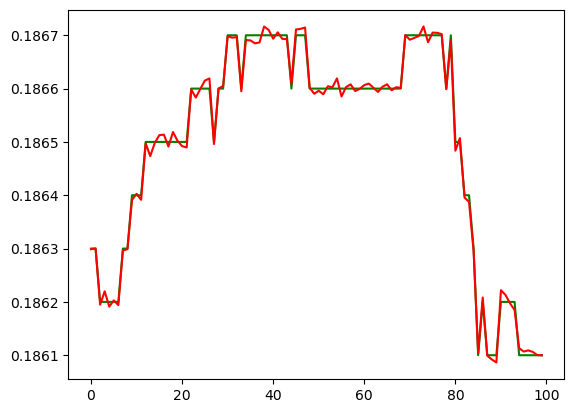

In [5]:
fig, ax = plt.subplots()
sns.lineplot(x=range(100), y=ticker_price[0,:100,2], ax=ax, color='green')
sns.lineplot(x=range(100), y=ticker_price_jitter[:100,2], ax=ax, color='red')
plt.show()

### scaling

In [6]:
ticker_price_scaling = np.zeros(ticker_price.shape)
for i in range(6):
    ticker_price_scaling[0,:,i] = aug.scaling(ticker_price[0,:,i], sigma=0.00005)

ticker_price_scaling = ticker_price_scaling[0,:,:]
ticker_price_scaling.shape

(450470, 6)

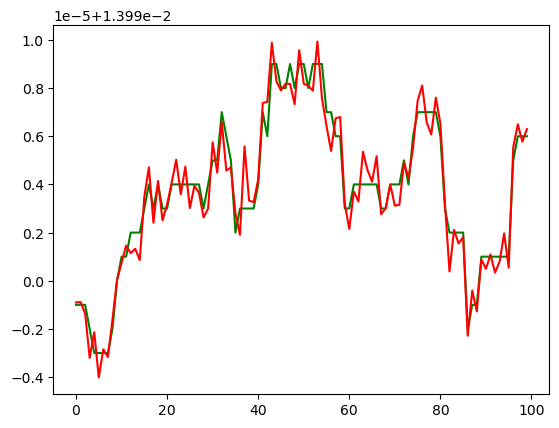

In [7]:
fig, ax = plt.subplots()
sns.lineplot(x=range(100), y=ticker_price[0,:100,0], ax=ax, color='green')
sns.lineplot(x=range(100), y=ticker_price_scaling[:100,0], ax=ax, color='red')
plt.show()

### time_warp

In [8]:
ticker_price_time_warp = aug.time_warp(ticker_price, sigma=0.002, knot=100)
ticker_price_time_warp = ticker_price_time_warp[0,:,:]
ticker_price_time_warp.shape

(450470, 6)

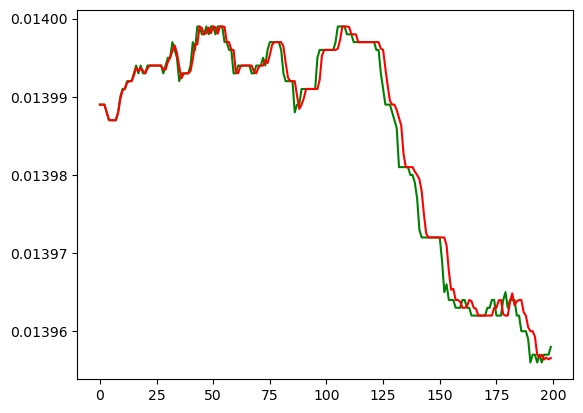

In [9]:
fig, ax = plt.subplots()
sns.lineplot(x=range(200), y=ticker_price[0,:200,0], ax=ax, color='green')
sns.lineplot(x=range(200), y=ticker_price_time_warp[:200,0], ax=ax, color='red')
plt.show()

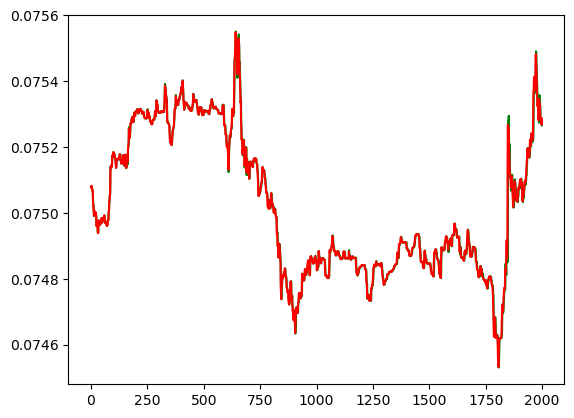

In [10]:
fig, ax = plt.subplots()
sns.lineplot(x=range(2000), y=ticker_price[0,:2000,1], ax=ax, color='green')
sns.lineplot(x=range(2000), y=ticker_price_time_warp[:2000,1], ax=ax, color='red')
plt.show()

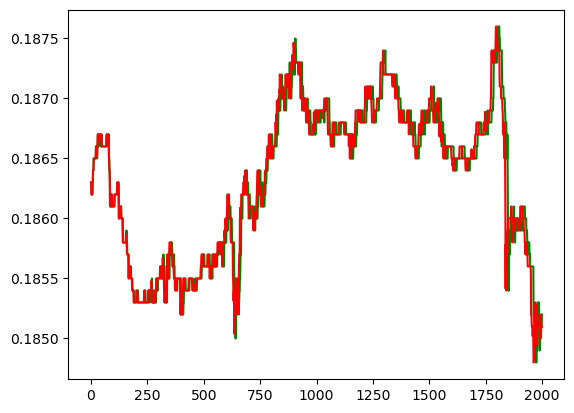

In [11]:
fig, ax = plt.subplots()
sns.lineplot(x=range(2000), y=ticker_price[0,:2000,2], ax=ax, color='green')
sns.lineplot(x=range(2000), y=ticker_price_time_warp[:2000,2], ax=ax, color='red')
plt.show()

### aug

In [12]:

ticker_price_aug_list = list()
for _ in tqdm(range(10)):
    ticker_price_aug = np.zeros(ticker_price.shape)
    for i in range(6):
        # jitter
        ticker_price_aug[0,:,i] = aug.jitter(ticker_price[0,:,i], sigma=np.std(ticker_price[0,:,i])/2000)
        # scaling
        ticker_price_aug[0,:,i] = aug.scaling(ticker_price_aug[0,:,i], sigma=0.00005)
    # time_warp
    ticker_price_aug = aug.time_warp(ticker_price_aug, sigma=0.002, knot=100)
    ticker_price_aug = ticker_price_aug[0,:,:]
    ticker_price_aug_list.append(ticker_price_aug)
    
ticker_price_aug = np.array(ticker_price_aug_list)
ticker_price_aug = np.reshape(ticker_price_aug, (-1, 6))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.40it/s]


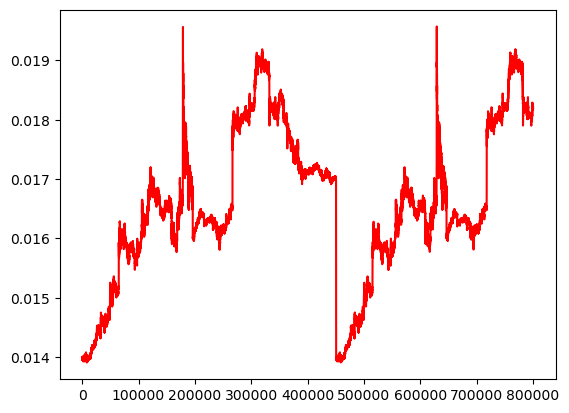

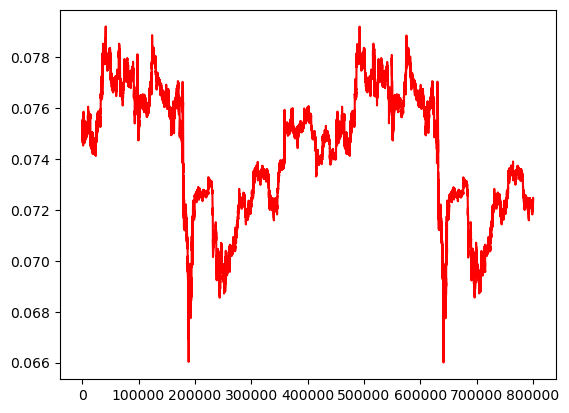

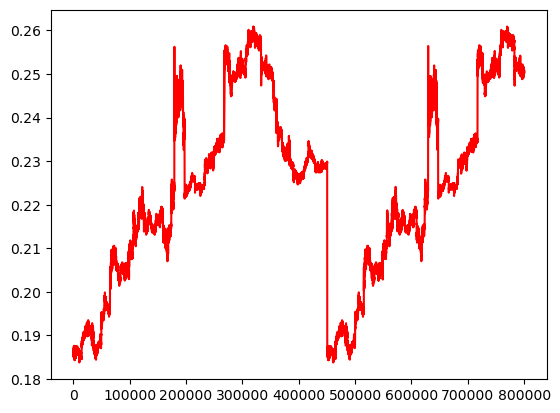

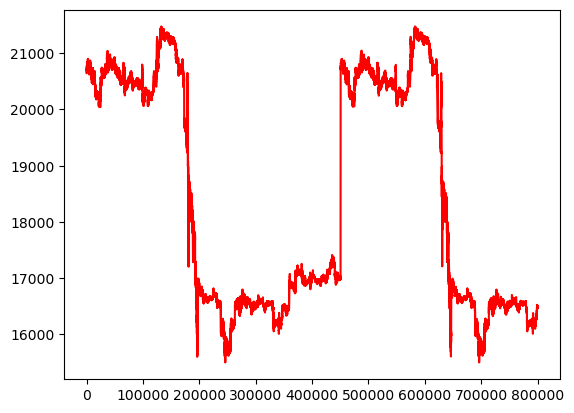

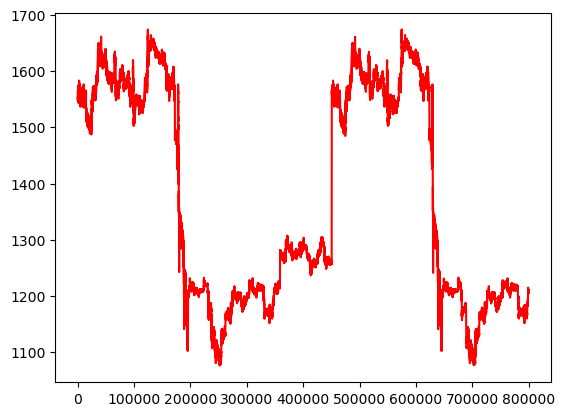

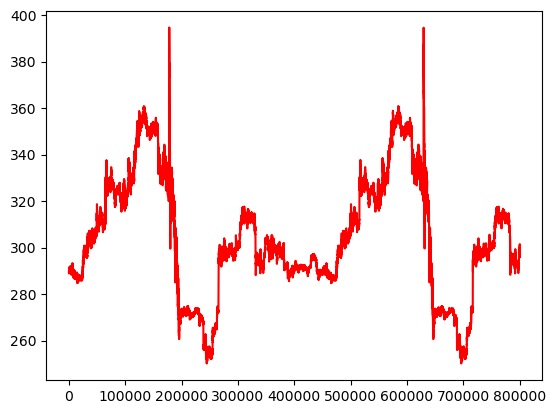

In [16]:
x_len = 800000
for i in range(6):
    fig, ax = plt.subplots()
    #sns.lineplot(x=range(x_len), y=ticker_price[0,:x_len,i], ax=ax, color='green')
    sns.lineplot(x=range(x_len), y=ticker_price_aug[:x_len,i], ax=ax, color='red')
    plt.show()